## LangGraph 时光旅行

+ 重放机制
+ 分叉机制


### 重试

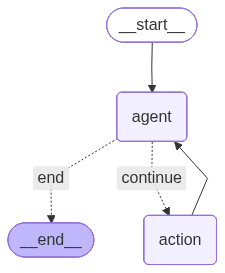

In [5]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv(".env", override=True)


@tool
def play_song_on_qq(song: str):
    """在QQ音乐上播放歌曲"""
    # 调用QQ音乐API
    return f"成功在QQ音乐上播放歌曲-{song}"


@tool
def play_song_on_163(song: str):
    """在网易云音乐上播放歌曲"""
    # 调用易云音乐API
    return f"成功在易云音乐上播放歌曲-{song}"


tools = [play_song_on_qq, play_song_on_163]
tool_node = ToolNode(tools)

model = ChatOpenAI(
    model=os.environ.get("DEEPSEEK_MODEL"),
    base_url=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)

bound_model = model.bind_tools(tools, parallel_tool_calls=False)


# 定义边


# 定义确定是否继续的函数
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # 如果没用函数调用，则结束
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"


# 定义节点


def call_model(state):
    messages = state["messages"]
    response = bound_model.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# 定义将循环的两个节点
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# 将入口设置为 agent
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    # 传入映射，键是字符串 值是其他节点
    {
        "continue": "action",
        "end": END,
    },
)
workflow.add_edge("action", "agent")

# 设置内存
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

# 查看
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# 调用
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="你能播放一首周杰伦播放量最高的歌曲吗？")

for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

你能播放一首周杰伦播放量最高的歌曲吗？
================================== Ai Message ==================================

我目前无法直接查询周杰伦播放量最高的歌曲。不过，我可以帮您在QQ音乐或网易云音乐上播放周杰伦的歌曲。

您希望使用哪个音乐平台来播放周杰伦的歌曲呢？比如《七里香》、《青花瓷》、《告白气球》等经典歌曲，您有特别想听的曲目吗？


In [23]:
# 查看记录并重放
app.get_state(config).values["messages"]

[HumanMessage(content='你能播放一首周杰伦播放量最高的歌曲吗？', additional_kwargs={}, response_metadata={}, id='5383d3ec-e9ca-46e9-bab2-56e9b5083747'),
 AIMessage(content='我目前无法直接查询周杰伦播放量最高的歌曲。不过，我可以帮您在QQ音乐或网易云音乐上播放周杰伦的歌曲。\n\n您希望使用哪个音乐平台来播放周杰伦的歌曲呢？比如《七里香》、《青花瓷》、《告白气球》等经典歌曲，您有特别想听的曲目吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 365, 'total_tokens': 438, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 320}, 'prompt_cache_hit_tokens': 320, 'prompt_cache_miss_tokens': 45}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'b508d0af-efb7-4e9f-9568-f89d71e5b21a', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b8815-636f-76f1-af38-3aa015e77fcb-0', usage_metadata={'input_tokens': 365, 'output_tokens': 73, 'total_tokens': 438, 'input_token_details': {'cache_read': 320}, 'output_token_details': {}})]

In [24]:
all_states = []
for state in app.get_state_history(config):
    print(state)
    all_states.append(state)
    print("--")

StateSnapshot(values={'messages': [HumanMessage(content='你能播放一首周杰伦播放量最高的歌曲吗？', additional_kwargs={}, response_metadata={}, id='5383d3ec-e9ca-46e9-bab2-56e9b5083747'), AIMessage(content='我目前无法直接查询周杰伦播放量最高的歌曲。不过，我可以帮您在QQ音乐或网易云音乐上播放周杰伦的歌曲。\n\n您希望使用哪个音乐平台来播放周杰伦的歌曲呢？比如《七里香》、《青花瓷》、《告白气球》等经典歌曲，您有特别想听的曲目吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 365, 'total_tokens': 438, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 320}, 'prompt_cache_hit_tokens': 320, 'prompt_cache_miss_tokens': 45}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'b508d0af-efb7-4e9f-9568-f89d71e5b21a', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b8815-636f-76f1-af38-3aa015e77fcb-0', usage_metadata={'input_tokens': 365, 'output_tokens': 73, 'total_tokens': 438, 'input_token_details': {'cache_read': 320}, 'output_

In [16]:
# 可以回到任何一个状态节点，并从那个时候重新开始操作

# 从第2个节点开始重新执行
to_replay = all_states[2]
to_replay.values


{'messages': [HumanMessage(content='我想听一首周杰伦播放量最高的歌', additional_kwargs={}, response_metadata={}, id='f28dcde4-2273-4d8b-8526-6b3c966a5462'),
  AIMessage(content='目前我无法直接查询周杰伦播放量最高的歌曲。不过，我可以帮您在QQ音乐或网易云音乐上播放周杰伦的歌曲。\n\n您可以告诉我具体想听周杰伦的哪首歌，比如：\n- 《七里香》\n- 《青花瓷》 \n- 《告白气球》\n- 《夜曲》\n- 《稻香》\n\n或者您有其他想听的周杰伦歌曲吗？我可以帮您在音乐平台上播放。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 363, 'total_tokens': 455, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 192}, 'prompt_cache_hit_tokens': 192, 'prompt_cache_miss_tokens': 171}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '1ce77892-4b2c-4967-b165-b07c16d62461', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b880b-acb1-7e72-ab26-270a94bf10e4-0', usage_metadata={'input_tokens': 363, 'output_tokens': 92, 'total_tokens': 455, 'input_token_details': {'cache_re

In [11]:
# 查看下一个节点
print(to_replay.next)

('action',)


In [12]:
# 从第二个节点重播
for event in app.stream(None, to_replay.config):
    for v in event.values():
        print(v)

{'messages': [ToolMessage(content='成功在QQ音乐上播放歌曲-周杰伦 告白气球', name='play_song_on_qq', id='d2badc42-cbb4-4b5d-8e8e-be008e9262b8', tool_call_id='call_00_JcnvuIGYvdq1nPsMNXKBHwee')]}
{'messages': [AIMessage(content='我已经在QQ音乐上为您播放了周杰伦的《告白气球》，这首歌是周杰伦近年来播放量非常高的热门歌曲之一。希望您喜欢！\n\n如果您想听其他周杰伦的歌曲，随时告诉我。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 684, 'total_tokens': 731, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 640}, 'prompt_cache_hit_tokens': 640, 'prompt_cache_miss_tokens': 44}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '70de974d-c7e0-4b81-a833-a7cad9c3bd7a', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b880d-913a-7091-8ea9-c96e30ccb9f3-0', usage_metadata={'input_tokens': 684, 'output_tokens': 47, 'total_tokens': 731, 'input_token_details': {'cache_read': 640}, 'output_token_deta

### 分叉操作

从某个节点开始操作，对执行数据进行分叉

In [ ]:
# 修改最后一个消息的工具调用
# 我们将其从`play_song_on_qq`更改为`play_song_on_163`

last_message = to_replay.values["messages"][-2]
last_message.tool_calls[0]["name"] = "play_song_on_163"

branch_config = app.update_state(
    to_replay.values,
    {"messages": [last_message]},
)

{}


AttributeError: 'HumanMessage' object has no attribute 'tool_calls'

In [ ]:
for event in app.stream(None, branch_config):
    for v in event.values():
        print(v)